In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [2]:
def rk4(x_init: np.ndarray, t_init: float, dt: float, f):
   '''
   Integrates the dynamics of `x_dot = f(x, t)` over a time interval `dt` given an initial state, `x_init`, and time, `t_init`
   using the RK4 algorithm.
   Returns the state at the end of the time interval `dt`.

   - x_init = Initial system state
   - t_init = Initial time
   - dt = Time interval over which `f` is integrated
   - f = f(t, x) - the function representing the time derivative of the state vector, `x`
   '''
   k1 = f(t_init, x_init)
   k2 = f(t_init + dt/2, x_init + dt * k1/2)
   k3 = f(t_init + dt/2, x_init + dt * k2/2)
   k4 = f(t_init + dt, x_init + dt * k3)

   return x_init + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)


In [3]:
def z_dot_dubins(z: np.ndarray, u: np.ndarray):
    '''
    z : [x, y, theta]
        x_pos, y_pos, orientation
        State of dynamical system
    u : [v, w]
        commanded speed, commanded angular velocity
        Control input for dynamical system
    Returns z_dot = f(z, u)
    '''
    z_dot = [u[0] * np.cos(z[2]), u[0] * np.sin(z[2]), u[1]]
    return np.array(z_dot)

In [32]:
def control_dubins(z: np.ndarray, gamma: float, h: float, k: float):
    '''
    z : [x, y, theta]
        x_pos, y_pos, orientation
        State of dynamical system
    z_target: [x, y, theta]
        Desired state of dynamical system
    gamma: exponential stabilization parameter > 0
    Assumes stabilizing to the origin with heading = 0
    '''
    p = np.sqrt(z[0]**2 + z[1]**2)
    theta = np.atan2(z[1], z[0])
    alpha = theta - z[2]
    u = -gamma * p * np.cos(alpha)
    w = -k * alpha + gamma * (np.sin(alpha) * np.cos(alpha) / alpha) * (alpha + h * theta)
    return np.array([u, w])

In [33]:
def make_regulated_dubins(gamma: float, h: float, k: float):
    f = lambda t, z: z_dot_dubins(z, control_dubins(z, gamma, h, k))
    return f

In [46]:
def regulated_dubins(z: np.ndarray, gamma: float, h: float, k: float):
    p = np.sqrt(z[0]**2 + z[1]**2)
    theta = np.atan2(z[1], z[0])
    alpha = theta - z[2]

    p_dot = -gamma * p * np.cos(alpha)**2
    theta_dot = gamma * np.sin(alpha) * np.cos(alpha)
    alpha_dot = -k * alpha - gamma * h * theta * np.sin(alpha) * np.cos(alpha) / alpha

    x_dot = p_dot * np.cos(theta) - p * theta_dot * np.sin(theta)
    y_dot = p_dot * np.sin(theta) + p * theta_dot * np.cos(theta)
    phi_dot = k * alpha + gamma * np.sin(alpha) * np.cos(alpha) * (alpha + h * theta) / alpha

    return np.array([x_dot, y_dot, phi_dot])

In [50]:
def make_regulated_dubins2(gamma: float, h: float, k: float):
    f = lambda t, z: regulated_dubins(z, gamma, h, k)
    return f

In [51]:
def run_experiment(z_init: np.ndarray):
    gamma = 3.0
    h = 1.0
    k = 6.0
    dt = 0.01
    states = []
    inputs = []
    # z_init = np.array([-10, 10, 2.9*np.pi/4])
    states.append(z_init)
    # uncomment this to show the shitty trajectories 
    # f = make_regulated_dubins(gamma, h, k)
    f = make_regulated_dubins2(gamma, h, k)
    t = 0.0
    
    for i in range(1000):
        z = rk4(states[-1], t, dt, f)
        inputs.append(control_dubins(z, gamma, h, k))
        t += dt
        # slacks.append(slack_dubins(states[-1], np.zeros(3), A, 2.0, 1000.))
        if (np.linalg.norm(states[-1][0:2]) < 0.001):
            break
        states.append(z)

    return states, inputs

In [52]:
init_states = [
    np.array([-1, 1, 2.9*np.pi/4]),
    np.array([-1, -1, -2.9*np.pi/4]),
    np.array([1, 1, 2.9*np.pi/4]),
    np.array([1, -1, -2.9*np.pi/4]),
    np.array([-.8, .3, 2.9*np.pi/4]),
    np.array([-.8, -.3, -2.9*np.pi/4]),
    np.array([.8, .3, 2.9*np.pi/4]),
    np.array([.8, -.3, -2.9*np.pi/4]),
    np.array([0.0, 1.0, 0.0]),
    np.array([0.0, -1.0, 0.0]),
]

trajectories = []

for init_state in init_states:
    trajectories.append(run_experiment(init_state)[0])

In [53]:
def plot_trajectories(trajs: List[np.ndarray]):
    for traj in trajs:
        pruned_states = [x for i, x in enumerate(traj) if i % 8 == 0]
        pruned_states.append(traj[-1])
        pruned_states.insert(0, traj[0])
        
        arrows = [[(x[0], x[1]), (x[0] + 0.1 * (1.0 - i / len(pruned_states)) * np.cos(x[2]), x[1] + 0.1 * (1.0 - i / len(pruned_states)) * np.sin(x[2]))] for i, x in enumerate(pruned_states)]
        
        plt.scatter([x[0] for x in pruned_states], [x[1] for x in pruned_states])
        for arrow in arrows:
            plt.plot([a[0] for a in arrow], [a[1] for a in arrow], color='orange')
    plt.title("trajectories")
    plt.axis("equal")
    plt.show()

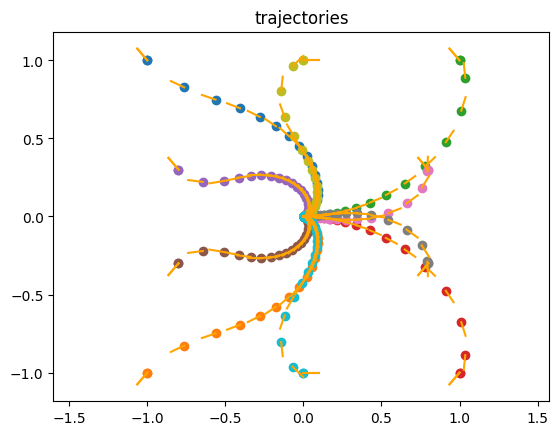

In [54]:
plot_trajectories(trajectories)

In [ ]:
# pruned_states = [x for i, x in enumerate(states) if i % 2 == 0]
# pruned_states.append(states[-1])
# pruned_states.insert(0, states[0])

# arrows = [[(x[0], x[1]), (x[0] + 0.4 * np.cos(x[2]), x[1] + 0.4 * np.sin(x[2]))] for x in pruned_states]

# plt.scatter([x[0] for x in pruned_states], [x[1] for x in pruned_states])
# for arrow in arrows:
#     plt.plot([a[0] for a in arrow], [a[1] for a in arrow], color='orange')
# plt.title("trajectory")
# plt.axis("equal")

## References

M. Aicardi, G. Casalino, A. Bicchi, A. Balestrino, 
"Closed loop steering of unicycle-like vehicles via Lyapunov techniques", 
IEEE 1995

J. M. Yang, J. H. Kim, 
"Sliding mode control for trajectory tracking of nonholonomic wheeled mobile robots", 
IEEE 1999